<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/19_4_Multi_Fidelity_Hyperparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1

In [ ]:
from collections import defaultdict
import numpy as np
from scipy import stats
from d2l import torch as d2l

In [ ]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler):
  def __init__(self, searcher, eta, r_min, r_max, prefact=1):
    self.save_hyperparameters()
    self.K = int(np.log(r_max / r_min) / np.log(eta))
    self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)]
    if r_max not in self.rung_levels:
      self.rung_levels.append(r_max)
      self.K += 1
    # Bookkeeping
    self.observed_error_at_rungs = defaultdict(list)
    self.all_observed_error_at_rungs = defaultdict(list)
    self.queue = []

In [ ]:
@d2l.add_to_class(SuccessiveHalvingScheduler)
def suggest(self):
  if len(self.queue) == 0:
    n0 = int(self.prefact * self.eta ** self.K)
    for _ in range(n0):
      config = self.searcher.sample_configuration()
      config["max_epochs"] = self.r_min
      self.queue.append(config)
  return self.queue.pop()

In [ ]:
@d2l.add_to_class(SuccessiveHalvingScheduler)
def update(self, config: dict, error: float, info=None):
  ri = int(config["max_epochs"])
  self.searcher.update(config, error, additional_info=info)
  self.all_observed_error_at_rungs[ri].append((config, error))
  if ri < self.r_max:
    self.observed_error_at_rungs[ri].append((config, error))
    ki = self.K = self.rung_levels.index(ri)
    ni = int(self.prefact * self.eta ** ki)
    if len(self.observed_error_at_rungs[ri]) >= ni:
      kiplus1 = ki - 1
      niplus1 = int(self.prefact * self.eta ** kiplus1)
      best_performing_configurations = self.get_top_n_configuations ( rung_level=ri, n=niplus1)
      riplus1 = self.rung_levels[self.K - kiplus1]
      self.queue = [ dict(config, max_epochs=riplus1)
      for config in best_performing_configurations] + self.queue
      self.observed_error_at_rungs[ri] = [] #Reset

In [ ]:
@d2l.add_to_class(SuccessiveHalvingScheduler)
def get_top_n_configuations(self, rung_level, n):
  rung = self.observed_error_at_rungs[rung_level]
  if not rung:
    return []
  sorted_rung = sorted(rung, key=lambda x: x[1])
  return [x[0] for x in sorted_rung[:n]]

In [ ]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2
num_gpus = 1
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

    error = 0.900085985660553, runtime = 65.98816347122192


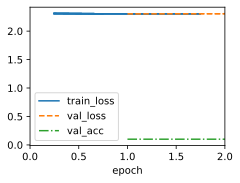

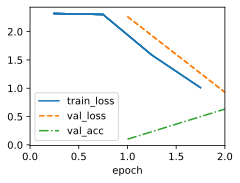

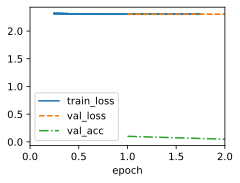

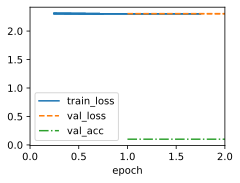

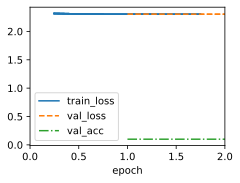

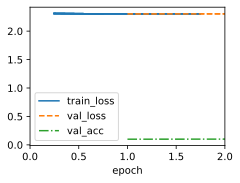

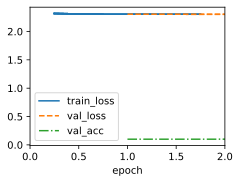

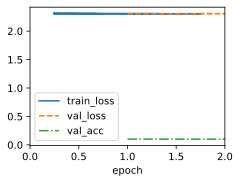

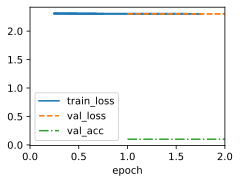

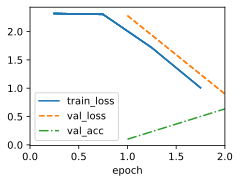

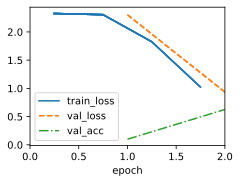

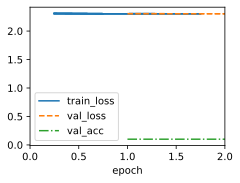

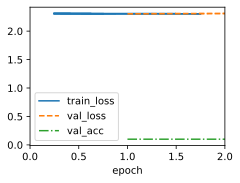

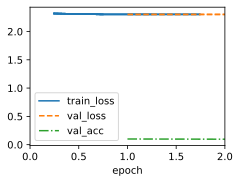

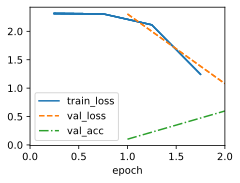

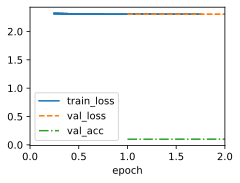

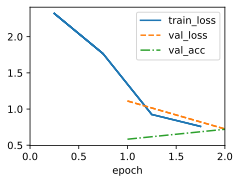

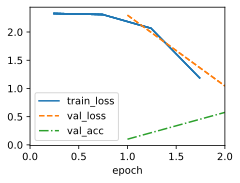

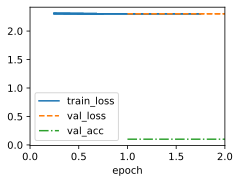

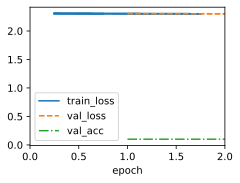

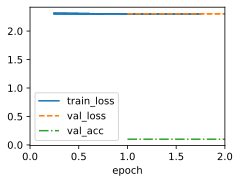

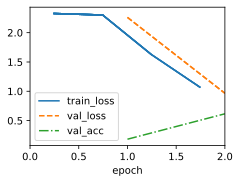

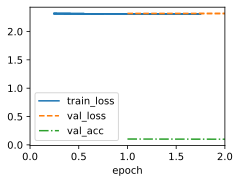

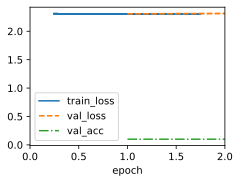

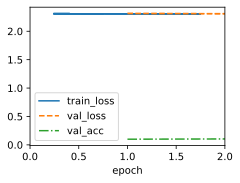

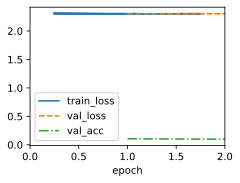

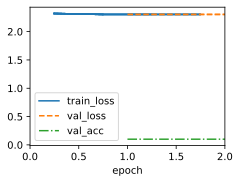

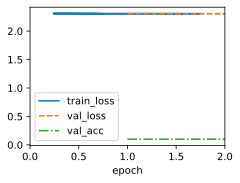

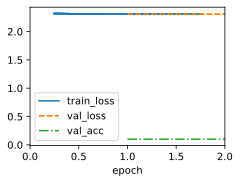

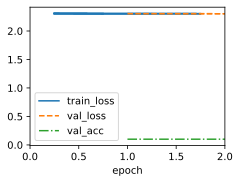

In [ ]:
searcher = d2l.RandomSearcher(config_space, initial_config=initial_config)
scheduler = SuccessiveHalvingScheduler(
    searcher = searcher,
    eta=eta,
    r_min=min_number_of_epochs,
    r_max=max_number_of_epochs,
)
tuner = d2l.HPOTuner(
    scheduler=scheduler,
    objective=d2l.hpo_objective_lenet,
)
tuner.run(number_of_trials=30)

Text(0.5, 0, 'epochs')

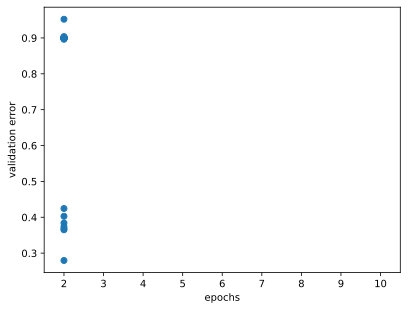

In [ ]:
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
  errors = [xi[1] for xi in rung]
  d2l.plt.scatter([rung_index] * len(errors), errors)
d2l.plt.xlim(min_number_of_epochs - 0.5, max_number_of_epochs + 0.5)
d2l.plt.xticks(
    np.arange(min_number_of_epochs, max_number_of_epochs + 1),
    np.arange(min_number_of_epochs, max_number_of_epochs + 1)
)
d2l.plt.ylabel("validation error")
d2l.plt.xlabel("epochs")